In [87]:
import numpy
import pandas

In [88]:
df = pandas.read_csv("../../data/raw/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [89]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [90]:
numerical = [
    "number_of_courses_viewed",
    "annual_income",
    "interaction_count",
    "lead_score",
]
categorical = ["lead_source", "industry", "employment_status", "location"]

df[numerical] = df[numerical].fillna(0.0)
df[categorical] = df[categorical].fillna("NA")

In [91]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(876, 293, 293)

In [92]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [93]:
del df_train["converted"]
del df_val["converted"]
del df_test["converted"]

Question 1: ROC AUC feature importance


In [94]:
from sklearn.metrics import roc_auc_score

auc_with_number_of_courses_viewed = roc_auc_score(
    y_train, df_train["number_of_courses_viewed"]
)
auc_with_annual_income = roc_auc_score(y_train, df_train["annual_income"])
auc_with_interaction_count = roc_auc_score(y_train, df_train["interaction_count"])
auc_with_lead_score = roc_auc_score(y_train, df_train["lead_score"])

auc_with_number_of_courses_viewed, auc_with_annual_income, auc_with_interaction_count, auc_with_lead_score

(0.7635680590007088, 0.5519578313253012, 0.738270176293409, 0.6144993577250176)

Question 2: Training the model


In [95]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
train_dicts

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

In [96]:
numpy.round(roc_auc_score(y_val, y_pred), 3)

np.float64(0.817)

Question 3: Precision and Recall


In [97]:
scores = []
thresholds = numpy.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, tn, fp, fn))

scores

columns = ["threshold", "tp", "tn", "fp", "fn"]
df_scores = pandas.DataFrame(scores, columns=columns)

In [98]:
df_scores["prec"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,tn,fp,fn,prec,recall
0,0.0,171,0,122,0,0.583618,1.000000
10,0.1,171,0,122,0,0.583618,1.000000
20,0.2,171,0,122,0,0.583618,1.000000
30,0.3,171,3,119,0,0.589655,1.000000
40,0.4,171,17,105,0,0.619565,1.000000
50,0.5,164,41,81,7,0.669388,0.959064
60,0.6,150,69,53,21,0.738916,0.877193
70,0.7,106,97,25,65,0.809160,0.619883
80,0.8,64,116,6,107,0.914286,0.374269
90,0.9,24,121,1,147,0.960000,0.140351


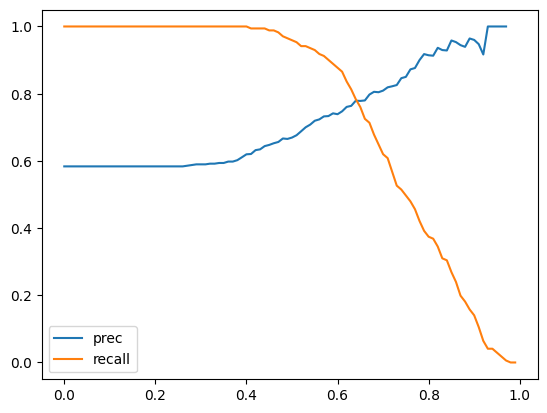

In [99]:
from matplotlib import pyplot as plt


plt.plot(df_scores.threshold, df_scores["prec"], label="prec")
plt.plot(df_scores.threshold, df_scores["recall"], label="recall")
plt.legend()

Question 4: F1 score


In [100]:
df_scores["f1"] = 2 * (
    (df_scores.prec * df_scores.recall) / (df_scores.prec + df_scores.recall)
)
print(df_scores.f1.idxmax())
df_scores.iloc[57]

57


threshold      0.570000
tp           156.000000
tn            65.000000
fp            57.000000
fn            15.000000
prec           0.732394
recall         0.912281
f1             0.812500
Name: 57, dtype: float64

Question 5: 5-Fold CV


In [101]:
from sklearn.model_selection import KFold


def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")

    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

scores
numpy.std(scores)

np.float64(0.03580711942905165)

Question 6: Hyperparameter Tuning


In [102]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [103]:
for C in [0.000001, 0.001, 1]:

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%s %.3f +- %.3f" % (C, numpy.mean(scores), numpy.std(scores)))

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
